In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import outgas_calc as calc

# Python Impurity Model B
Starting from the ground up. Less modularity for now. Contains specific references to certain datasets from a PTFE/Oxygen setup.
## Constants
The following are constants for the Teflon/Oxygen pair.

In [3]:
ACTIVATION_ENERGY = 0.46 # activation energy in eV
D_0 = 26 # Diffusion constant at infinite temperature, in cm^2/s
SOLUBILITY = 0.22 # fractional volume of gas per volume of polymer
O2_ABUNDANCE = 0.21
ATMOS_PRESSURE = 101325 # in Pa
INITIAL_TEMP = 273 # in kelvin
THICKNESS = 0.75 # of sample, in cm
SURFACE_AREA = 62.02 # surface area of sample, in cm^2
k_b = 1.381e-22 # Boltzmann constant in mbar-liters/kelvin

## Data Import

In [4]:
full_data = pd.read_csv('setup4_cline_3T.csv', index_col=0)
full_data

,t,min_T,med_T,max_T
0,0,292.920990,293.150000,293.254650
1,1,293.150000,293.150033,300.743630
2,2,293.150026,293.151571,301.669913
3,3,293.150595,293.160096,302.015727
4,4,293.151643,293.174323,302.180704
...,...,...,...,...
3596,3596,303.149985,303.149988,303.150000
3597,3597,303.149985,303.149988,303.150000
3598,3598,303.149985,303.149988,303.150000
3599,3599,303.149985,303.149988,303.150000


For now, let's just use the centerline median temperature data.

In [5]:
#times = full_data['t'].to_numpy()
median_temps = full_data['med_T'].to_numpy()

In [6]:
# room temperature only as a check
room_temp = np.zeros(3601)
room_temp.fill(293)

In [7]:
# 1 hour of room temperature, 1 hour of heating
synth_run = np.concatenate((room_temp, median_temps))
times = np.arange(synth_run.shape[0])

Calculate the initial concentration of $O_2$ in the sample. Last constant of the setup.

In [8]:
c_0 = calc.get_initial_concentration(SOLUBILITY, O2_ABUNDANCE, ATMOS_PRESSURE, INITIAL_TEMP) # result in cm^-3
c_0

1.241658775692085e+18

Calculate the diffusion constants for all temperatures in the dataset.

In [9]:
diff_consts = calc.arrhenius_relation(D_0, ACTIVATION_ENERGY, synth_run)
#room_temp_diffs = calc.arrhenius_relation(D_0, ACTIVATION_ENERGY, room_temp)
#diff_consts

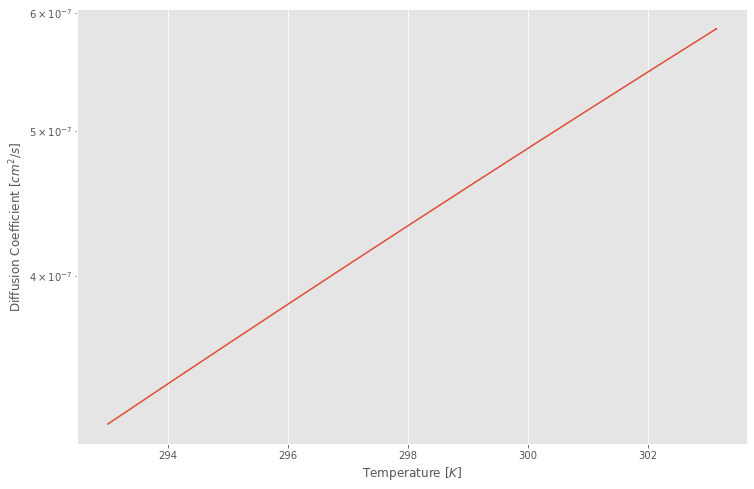

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(synth_run, diff_consts)
plt.yscale("log")
plt.ylabel("Diffusion Coefficient [$cm^2/s$]")
plt.xlabel("Temperature [$K$]")
plt.show()

Calculate the concentration and outgassing rate for the setup.

In [11]:
conc = calc.get_concentrations(c_0, diff_consts, THICKNESS, times)
# convert concentration from atoms per cm^2 to mbar-liters
conc = conc * SURFACE_AREA
conc = conc * k_b * synth_run
rates = calc.get_flow_rate(c_0, diff_consts, THICKNESS, times)
# convert rates from atoms per cm^2 per second to mbar-liters / second
rates = rates * SURFACE_AREA
rates = rates * k_b * synth_run

In [12]:
#room_temp_conc = calc.get_concentrations(c_0, room_temp_diffs, THICKNESS, times)
#room_temp_rates = calc.get_flow_rate(c_0, room_temp_diffs, THICKNESS, times)

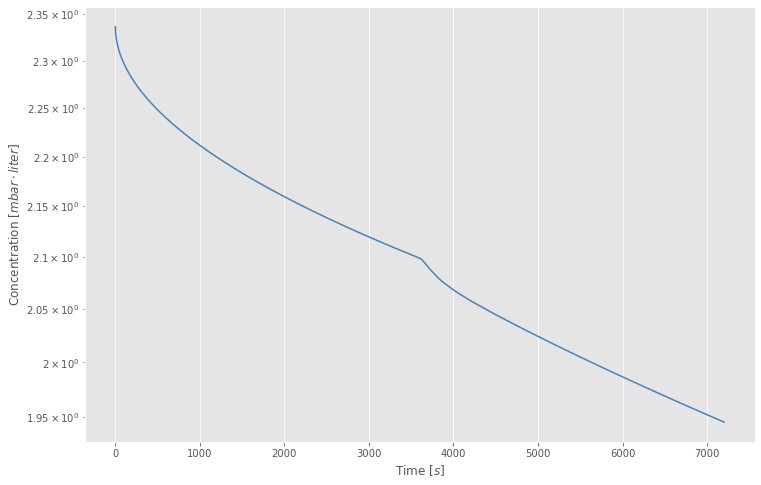

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(times, conc, label='Heated', color='steelblue')
#plt.plot(times, room_temp_conc, label='Room Temperature')
plt.yscale("log")
plt.ylabel("Concentration [$mbar\cdot liter$]")
plt.xlabel("Time [$s$]")
#plt.legend()
plt.show()

In [14]:
rates

array([5.28795382e-03, 9.91670030e-04, 7.01216603e-04, ...,
       1.64051221e-05, 1.64039828e-05, 1.64028438e-05])

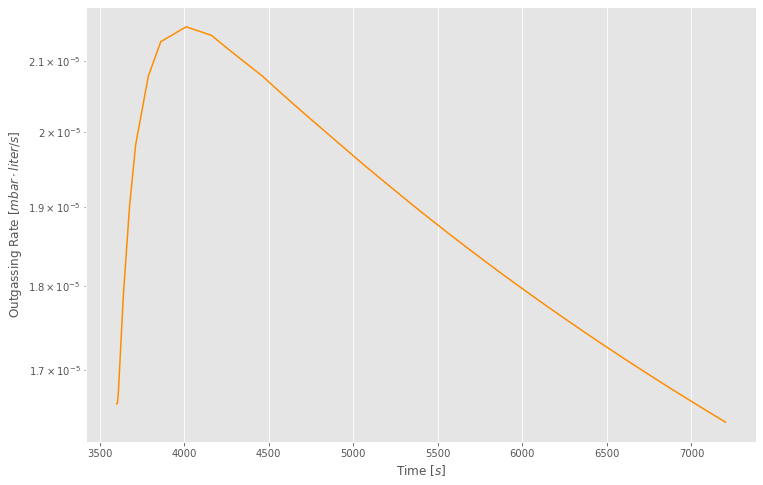

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(times[3601:], rates[3601:], label='Heated', color='darkorange')
#plt.plot(times, room_temp_rates, label='Room Temperature')
plt.yscale("log")
plt.ylabel("Outgassing Rate [$mbar\cdot liter/s$]")
plt.xlabel("Time [$s$]")
#plt.legend()
plt.show()